In [3]:
# Imports
%load_ext autoreload
%aimport sym
%autoreload 1
import os 
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sym import LCN, ProgressBar, Classification_report, Logger
from sym.utils import utils
device = "cuda:0" if torch.cuda.is_available() else "cpu"
plt.style.use('dark_background')

In [21]:
testset = torch.load("./data/testset.pt")
trainset = torch.load("./data/trainset.pt")
trainset, valset = torch.utils.data.random_split(trainset,[55000,5000])
trainloader = torch.utils.data.DataLoader(trainset, num_workers=6, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, num_workers=6)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=6)
del testset, trainset, valset

Text(0.5, 0.91, 'Validation Data')

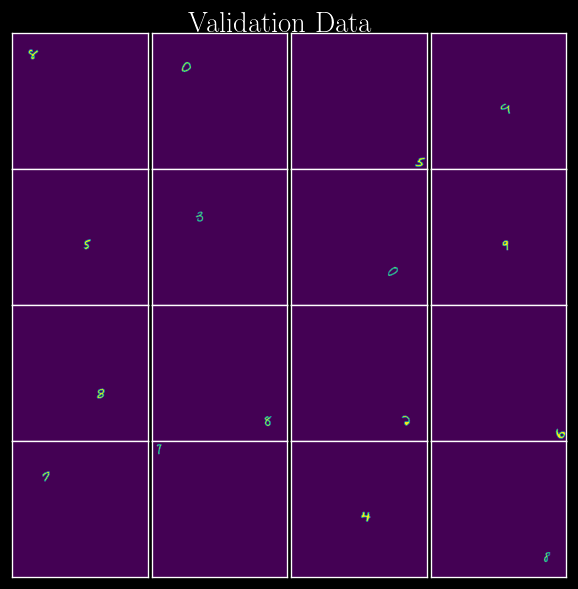

In [104]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
x,y = next(iter(trainloader))
for img,label, ax in zip(x,y,axes.flatten()):
    ax.imshow(img.squeeze().numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("Validation Data", y=.91)

In [6]:
# Aggregate validation losses -> DONE!
# Change back to SGD -> DONE!
# Reporoduce their experiments -> DONE!
# Fix LCN Code -> DONE!
# Think about better problem statement for CNN vs LCN
# Shit on computaional separation paper (for not having large enough FCN)
# Show that the bounds are consistent
# By Friday have 5 pages

In [27]:
logdir = "./lightning_logs/MNIST/"
if not os.path.exists(logdir): os.makedirs(logdir,exist_ok=True)

In [28]:
# Train the CNN 
epochs = 10
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
module = sym.models.CNN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
cnn = sym.models.Model(module,
    optim=torch.optim.Adam(module.parameters(),lr=1e-6,weight_decay=1e-3))

In [29]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="CNN",default_hp_metric=False)
path = logdir+f"CNN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(cnn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/CNN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 1.8 M 


Epoch 39: 100%|##########| 1876/1876 [00:20<00:00, 92.02it/s, loss=0.009, v_num=0, val_loss=0.0112, val_acc=0.928]


1

# LCN 

In [32]:
# Train the LCN 
epochs = 10
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
module = sym.models.LCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
lcn = sym.models.Model(module,
    optim=torch.optim.Adam(module.parameters(),lr=1e-6,weight_decay=1e-3))

In [36]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="LCN",default_hp_metric=False)
path = logdir+f"LCN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(lcn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/LCN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | LCN  | 21.7 M


Epoch 39: 100%|##########| 1876/1876 [01:26<00:00, 21.79it/s, loss=0.010, v_num=0, val_loss=0.0126, val_acc=0.925]


1

# FCN 

In [61]:
%autoreload

In [62]:
# Train the FCN 
epochs = 40
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
module = sym.models.FCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
fcn = sym.models.Model(module,
    optim=torch.optim.Adam(module.parameters(),lr=1e-6,weight_decay=1e-3))

In [63]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="FCN",default_hp_metric=False)
path = logdir+f"FCN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(fcn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/FCN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FCN  | 20.1 M


Epoch 39: 100%|##########| 1876/1876 [00:24<00:00, 76.36it/s, loss=0.002, v_num=0, val_loss=0.00956, val_acc=0.941]


1

In [69]:
weights_fcn = next(fcn.model.parameters()).detach().cpu()
filters_fcn = utils.minmaxnorm(weights_fcn)

Text(0.5, 0.91, 'FCN Filters')

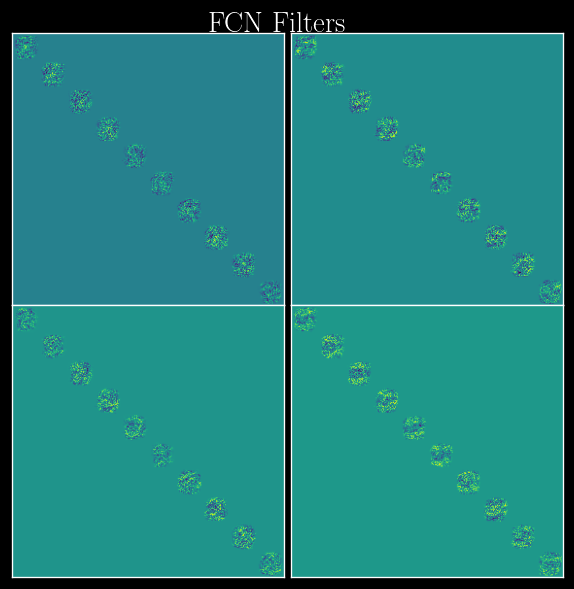

In [80]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_fcn[100:],axes.flatten()):
    ax.imshow(img.view(280,280).numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("FCN Filters", y=.91)

Text(0.5, 0.91, 'CNN Filters')

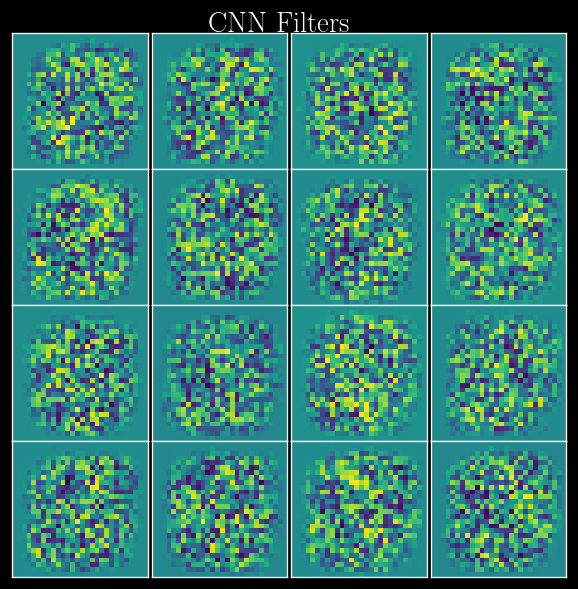

In [95]:
weights_cnn = next(cnn.model.parameters()).detach().cpu().squeeze()
filters_cnn = utils.minmaxnorm(weights_cnn)
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_cnn,axes.flatten()):
    ax.imshow(img.numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("CNN Filters", y=.91)

In [101]:
weights_lcn = next(lcn.model.parameters()).detach().cpu().squeeze()
weights_lcn = weights_lcn.unflatten(0,(nfilters,10,10)) #get filter locations
weights_lcn = weights_lcn.permute(0,1,3,2,4) # height and width next to each other
weights_lcn = weights_lcn.flatten(1,2).flatten(2,3)

torch.Size([256, 280, 280])

Text(0.5, 0.91, 'LCN Filters')

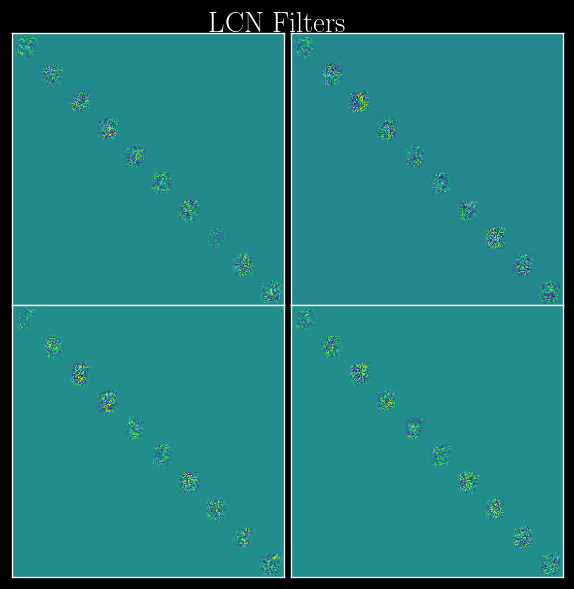

In [119]:
filters_lcn = utils.minmaxnorm(weights_lcn)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_lcn[200:],axes.flatten()):
    ax.imshow(img.numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("LCN Filters", y=.91)

In [123]:
# Loading a model
# module2 = sym.models.FCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
#                      kernel_size=kernel_size, stride=stride, readout_activation=None)
# fcn2 = sym.models.Model(module,
#     optim=torch.optim.Adam(module.parameters(),lr=1e-6,weight_decay=1e-3))
# fcn2.load_from_checkpoint("lightning_logs/MNIST/FCN/version_0/weights.cpkt-v0.ckpt", model = module2)